In [ ]:
import keras
import tensorflow
print("Tensorflow version " + tensorflow.__version__)
print("Keras version " + tensorflow.keras.__version__)

In [ ]:
from keras import Input
from keras.applications import VGG19
from keras.callbacks import TensorBoard
from keras.layers import BatchNormalization, Activation, LeakyReLU, Add, Dense
from keras.layers.convolutional import Conv2D, UpSampling2D
from keras.models import Model
from keras.optimizers import Adam

import glob
import os
import imageio
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random

from numpy import asarray

from imageio import imread

## From cv2 import imread
from skimage.transform import resize as imresize

## From cv2 import resize as imresize
from PIL import Image

In [ ]:
import cv2
from cv2 import rectangle

In [ ]:
## Use fixed seeds for random number generators to guarantee reproducible results

In [ ]:
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
tensorflow.random.set_seed(SEED)

In [ ]:
## Define some hyper-parameters

In [ ]:
## Let's start with 201 epochs for now, bit keep in mind, that it might be necessary to train more afterwards
epochs1 = 201
epochs2 = 201
epochs3 = 201

## Let's start from batch size equals to 8 (due to RAM limits)
batch_size = 8

## Define the shape of low resolution image (LR)
low_resolution_shape = (64, 64, 3)

## Define the shape of high resolution image (HR)
high_resolution_shape = (256, 256, 3)

## For simplicity let's start with Adam
common_optimizer1 = Adam(0.0002, 0.5)
common_optimizer2 = Adam(0.0002, 0.5)
common_optimizer3 = Adam(0.0002, 0.5)

In [ ]:
## Load and Transform the LFW Data
## LFW dataset contains images (photos) of people provided with attribute labels

In [ ]:
data_dir = "/Your Data Dir/*/*.*"

In [ ]:
## PSNR - Peak Signal-to-Noise Ratio
## PSNR is the ratio between maximum possible power of signal and power of corrupting noise

In [ ]:
def calc_psnr(original_image, generated_image):
    original_image = tensorflow.convert_to_tensor(original_image, dtype=tensorflow.float32)
    generated_image = tensorflow.convert_to_tensor(generated_image, dtype=tensorflow.float32)
    psnr = tensorflow.image.psnr(original_image, generated_image, max_val=1.0)
    return tensorflow.math.reduce_mean(psnr, axis=None, keepdims=False, name=None)

In [ ]:
def plot_psnr(psnr, title):
    psnr_means = psnr['psnr_quality']
    plt.figure(figsize=(10,8))
    plt.plot(psnr_means, label="PSNR quality: " + title)
    plt.xlabel('Epochs')
    plt.ylabel('PSNR')
    plt.legend()
    plt.show()

In [ ]:
def plot_psnr12(psnr_1, psnr_2, title1, title2):
    psnr_1_means = psnr_1['psnr_quality']
    psnr_2_means = psnr_2['psnr_quality']
    plt.figure(figsize=(10,8))
    plt.plot(psnr_1_means, label="PSNR quality: " + title1)
    plt.plot(psnr_2_means, label="PSNR quality: " + title2)
    plt.xlabel('Epochs')
    plt.ylabel('PSNR')
    plt.legend()
    plt.show()

In [ ]:
def plot_psnr123(psnr_1, psnr_2, psnr_3, title1, title2, title3):
    psnr_1_means = psnr_1['psnr_quality']
    psnr_2_means = psnr_2['psnr_quality']
    psnr_3_means = psnr_3['psnr_quality']
    
    plt.figure(figsize=(10,8))
    plt.plot(psnr_1_means, label="PSNR quality: " + title1)
    plt.plot(psnr_2_means, label="PSNR quality: " + title2)
    plt.plot(psnr_3_means, label="PSNR quality: " + title3)
    
    plt.xlabel('Epochs')
    plt.ylabel('PSNR')
    plt.legend()
    plt.show()

In [ ]:
## SSIM - Structural Similarity Index
## SSIM measures the perceptual difference between two similar images

In [ ]:
def calc_ssim(original_image, generated_image):
    original_image = tensorflow.convert_to_tensor(original_image, dtype=tensorflow.float32)
    generated_image = tensorflow.convert_to_tensor(generated_image, dtype=tensorflow.float32)
    ssim = tensorflow.image.ssim(original_image, generated_image, max_val=1.0, filter_size=11,
    filter_sigma=1.5, k1=0.01, k2=0.03)
    return tensorflow.math.reduce_mean(ssim, axis=None, keepdims=False, name=None)

In [ ]:
def plot_ssim(ssim, title):
    ssim_means = ssim['ssim_quality']
    plt.figure(figsize=(10,8))
    plt.plot(ssim_means, label="SSIM quality: " + title)
    plt.xlabel('Epochs')
    plt.ylabel('SSIM')
    plt.legend()
    plt.show()

In [ ]:
def plot_ssim12(ssim_1, ssim_2, title1, title2):
    ssim_1_means = ssim_1['ssim_quality']
    ssim_2_means = ssim_2['ssim_quality']
    
    plt.figure(figsize=(10,8))
    plt.plot(ssim_1_means, label="SSIM quality: " + title1)
    plt.plot(ssim_2_means, label="SSIM quality: " + title2)
    
    plt.xlabel('Epochs')
    plt.ylabel('SSIM')
    plt.legend()
    plt.show()

In [ ]:
def plot_ssim123(ssim_1, ssim_2, ssim_3, title1, title2, title3):
    ssim_1_means = ssim_1['ssim_quality']
    ssim_2_means = ssim_2['ssim_quality']
    ssim_3_means = ssim_3['ssim_quality']
    
    plt.figure(figsize=(10,8))
    plt.plot(ssim_1_means, label="SSIM quality: " + title1)
    plt.plot(ssim_2_means, label="SSIM quality: " + title2)
    plt.plot(ssim_3_means, label="SSIM quality: " + title3)
    
    plt.xlabel('Epochs')
    plt.ylabel('SSIM')
    plt.legend()
    plt.show()

In [ ]:
## Loss Functions

In [ ]:
## MSE = Pixel-by-Pixel Mean Squared Error
## MSE works if the goal is to generate a picture having the best pixel colors conformity with the ground truth picture. However, in real-life scenarios it might be necessary to concentrate on the structure or relief of the picture.

## Perceptual Loss is a weighted sum of the content loss and adversarial loss

## Content Loss can be of two types:
## Pixel-wise MSE loss mean squared error between each pixel in real image and a pixel in generated image
## VGG loss is the Euclidean distance between the feature maps of the generated image and the real image

## Adversarial Loss is calculated based on probabilities provided by Discriminator

## Discriminator is trained to solve maximization:
## Generator is trained to solve minimization:

In [ ]:
## Plotting loss, sampling images, saving images

In [ ]:
def plot_loss(losses, title):
    d_loss = losses['d_history']
    g_loss = losses['g_history']
    
    plt.figure(figsize=(10,8))
    plt.plot(d_loss, label="Discriminator loss: " + title)
    plt.plot(g_loss, label="Generator loss: " + title)
    
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [ ]:
def plot_loss12(losses1, losses2, title1, title2):
    d_loss1 = losses1['d_history']
    g_loss1 = losses1['g_history']
    d_loss2 = losses2['d_history']
    g_loss2 = losses2['g_history']
    
    plt.figure(figsize=(10,8))
    plt.plot(d_loss1, label="Discriminator loss: " + title1)
    plt.plot(g_loss1, label="Generator loss: " + title1)
    plt.plot(d_loss2, label="Discriminator loss: " + title2)
    plt.plot(g_loss2, label="Generator loss: " + title2)
    
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [ ]:
def plot_loss123(losses1, losses2, losses3, title1, title2, title3):
    d_loss1 = losses1['d_history']
    g_loss1 = losses1['g_history']
    d_loss2 = losses2['d_history']
    g_loss2 = losses2['g_history']
    d_loss3 = losses3['d_history']
    g_loss3 = losses3['g_history']
    
    plt.figure(figsize=(10,8))
    plt.plot(d_loss1, label="Discriminator loss: " + title1)
    plt.plot(g_loss1, label="Generator loss: " + title1)
    plt.plot(d_loss2, label="Discriminator loss: " + title2)
    plt.plot(g_loss2, label="Generator loss: " + title2)
    plt.plot(d_loss3, label="Discriminator loss: " + title3)
    plt.plot(g_loss3, label="Generator loss: " + title3)
    
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [ ]:
## Let's detect and extract faces and eyes

In [ ]:
import mtcnn
from mtcnn import MTCNN

In [ ]:
def sample_images(data_dir, batch_size, high_resolution_shape, low_resolution_shape):
    ## Create the list of all images, which are inside of data_dir catalogue
    all_images = glob.glob(data_dir)
    ## Select a random batch with images
    images_batch = np.random.choice(all_images, size=batch_size)
    low_resolution_images = []
    high_resolution_images = []
    low_resolution_images_det = []
    high_resolution_images_det = []
    low_resolution_faces = []
    high_resolution_faces = []
    low_resolution_faces_det = []
    high_resolution_faces_det = []
    low_resolution_right_eyes = []
    high_resolution_right_eyes = []
    low_resolution_left_eyes = []
    high_resolution_left_eyes = []
    detector = MTCNN()
    for img in images_batch:
        img1 = imread(img, as_gray=False, pilmode='RGB')
        ## img1 = imread(img)
        ## img1 = plt.imread(img)
        results = detector.detect_faces(img1)
        if len(results) == 0 or results[0]['box'][2] == 0 or results[0]['box'][3] == 0:
            face = img1
            img2 = np.copy(img1)
            face_det = img2
            right_eye = img1
            left_eye = img1
        else:
            x1_face, y1_face, width_face, height_face = results[0]['box']
            bounding_box = results[0]['box']
            x1_face = bounding_box[0]
            y1_face = bounding_box[1]
            width_face = bounding_box[2]
            height_face = bounding_box[3]
            keypoints = results[0]['keypoints']
            x2_face, y2_face = x1_face + width_face, y1_face + height_face
            face = img1[y1_face:y2_face, x1_face:x2_face]
            if face.shape[0] == 0 or face.shape[0] == 0 or face.size == 0:
                face = img1
                img2 = np.copy(img1)
                face_det = img2
                right_eye = img1
                left_eye = img1
            else:
                x1_right_eye, y1_right_eye = list(results[0]['keypoints']['right_eye'])
                x1_left_eye, y1_left_eye = list(results[0]['keypoints']['left_eye'])
                width_eye = width_face // 5
                height_eye = height_face // 5
                x1_right_eye, y1_right_eye = int(x1_right_eye - 0.5 * width_eye), int(y1_right_eye - 0.5 * height_eye)
                x2_right_eye, y2_right_eye = int(x1_right_eye + width_eye), int(y1_right_eye + height_eye)
                x1_left_eye, y1_left_eye = int(x1_left_eye - 0.5 * width_eye), int(y1_left_eye - 0.5 * height_eye)
                x2_left_eye, y2_left_eye = int(x1_left_eye + width_eye), int(y1_left_eye + height_eye)
                right_eye = img1[y1_right_eye:y2_right_eye, x1_right_eye:x2_right_eye]
                left_eye = img1[y1_left_eye:y2_left_eye, x1_left_eye:x2_left_eye]
                ## img2 = np.copy(img1)
                img2 = img1
                rectangle(img2, (x1_face, y1_face), (x2_face, y2_face), (0,0,255), 1)
                rectangle(img2, (x1_right_eye, y1_right_eye), (x2_right_eye, y2_right_eye), (0,0,255), 1)
                rectangle(img2, (x1_left_eye, y1_left_eye), (x2_left_eye, y2_left_eye), (0,0,255), 1)
                face_det = img2[y1_face:y2_face, x1_face:x2_face]
            face = face.astype(np.float32)
            face_det = face_det.astype(np.float32)
            right_eye = right_eye.astype(np.float32)
            left_eye = left_eye.astype(np.float32)
            img1 = img1.astype(np.float32)
            img2 = img2.astype(np.float32)
            ## Change the size
            img1_high_resolution = imresize(img1, high_resolution_shape)
            img1_low_resolution = imresize(img1, low_resolution_shape)
            img2_high_resolution = imresize(img2, high_resolution_shape)
            img2_low_resolution = imresize(img2, low_resolution_shape)
            face_high_resolution = imresize(face, high_resolution_shape)
            face_low_resolution = imresize(face, low_resolution_shape)
            face_high_resolution_det = imresize(face_det, high_resolution_shape)
            face_low_resolution_det = imresize(face_det, low_resolution_shape)
            right_eye_high_resolution = imresize(right_eye, high_resolution_shape)
            right_eye_low_resolution = imresize(right_eye, low_resolution_shape)
            left_eye_high_resolution = imresize(left_eye, high_resolution_shape)
            left_eye_low_resolution = imresize(left_eye, low_resolution_shape)
            high_resolution_images.append(img1_high_resolution)
            low_resolution_images.append(img1_low_resolution)
            high_resolution_images_det.append(img2_high_resolution)
            low_resolution_images_det.append(img2_low_resolution)
            high_resolution_faces.append(face_high_resolution)
            low_resolution_faces.append(face_low_resolution)
            high_resolution_faces_det.append(face_high_resolution)
            low_resolution_faces_det.append(face_low_resolution)
            high_resolution_right_eyes.append(right_eye_high_resolution)
            low_resolution_right_eyes.append(right_eye_low_resolution)
            high_resolution_left_eyes.append(left_eye_high_resolution)
            low_resolution_left_eyes.append(left_eye_low_resolution)
            ## Convert lists into numpy ndarrays
    return np.array(high_resolution_images), np.array(low_resolution_images), np.array(high_resolution_images_det), np.array(low_resolution_images_det), np.array(high_resolution_faces), np.array(low_resolution_faces), np.array(high_resolution_faces_det), np.array(low_resolution_faces_det), np.array(high_resolution_right_eyes), np.array(low_resolution_right_eyes), np.array(high_resolution_left_eyes), np.array(low_resolution_left_eyes)

In [ ]:
def save_images(low_resolution_image, original_image, generated_image, path):
    ## Save low-resolution, high-resolution(original) and generated high-resolution images into one picture
    fig = plt.figure()
    ax = fig.add_subplot(1, 3, 1)
    ax.imshow(original_image)
    ax.axis("off")
    ax.set_title("ORIGINAL")
    ax = fig.add_subplot(1, 3, 2)
    ax.imshow(low_resolution_image)
    ax.axis("off")
    ax.set_title("LOW_RESOLUTION")
    ax = fig.add_subplot(1, 3, 3)
    ax.imshow(generated_image)
    ax.axis("off")
    ax.set_title("GENERATED")
    plt.savefig(path)

In [ ]:
## Experiment 1 - SRGAN-VGG19

In [ ]:
## Generator
## The code is based on SRGAN implementation with several experimental changes

In [ ]:
def residual_block(x):
    filters = [64, 64]
    kernel_size = 3
    strides = 1
    padding = "same"
    momentum = 0.8
    activation = "relu"
    res = Conv2D(filters=filters[0], kernel_size=kernel_size, strides=strides, padding=padding)(x)
    res = Activation(activation=activation)(res)
    res = BatchNormalization(momentum=momentum)(res)
    res = Conv2D(filters=filters[1], kernel_size=kernel_size, strides=strides, padding=padding)(res)
    res = BatchNormalization(momentum=momentum)(res)
    res = Add()([res, x])
    return res

In [ ]:
def build_generator1():
    ## Use 16 residual blocks in generator
    residual_blocks = 16
    momentum = 0.8
    ## Dimension equals to LR - Low Resolution
    input_shape = (64, 64, 3)
    ## Input layer for the generator network
    input_layer = Input(shape=input_shape)
    ## Pre-residual block: convolutional layer before residual blocks
    gen1 = Conv2D(filters=64, kernel_size=9, strides=1, padding='same', activation='relu')(input_layer)
    ## Add 16 residual blocks
    res = residual_block(gen1)
    for i in range(residual_blocks - 1):
        res = residual_block(res)
    ## Post-residual block: convolutional layer and batch-norm layer after residual blocks
    gen2 = Conv2D(filters=64, kernel_size=3, strides=1, padding='same')(res)
    gen2 = BatchNormalization(momentum=momentum)(gen2)
    ## Take the sum of pre-residual block(gen1) and post-residual block(gen2)
    gen3 = Add()([gen2, gen1])
    ## UpSampling: learning to increase dimensionality
    gen4 = UpSampling2D(size=2)(gen3)
    gen4 = Conv2D(filters=256, kernel_size=3, strides=1, padding='same')(gen4)
    gen4 = Activation('relu')(gen4)
    ## UpSampling: learning to increase dimensionality
    gen5 = UpSampling2D(size=2)(gen4)
    gen5 = Conv2D(filters=256, kernel_size=3, strides=1, padding='same')(gen5)
    gen5 = Activation('relu')(gen5)
    ## Convolution layer at the output
    gen6 = Conv2D(filters=3, kernel_size=9, strides=1, padding='same')(gen5)
    output = Activation('tanh')(gen6)
    ## Model
    model = Model(inputs=[input_layer], outputs=[output], name='generator')
    return model

In [ ]:
generator1 = build_generator1()

In [ ]:
## Discriminator

In [ ]:
def build_discriminator1():
    ## Define hyper-parameters
    leakyrelu_alpha = 0.2
    momentum = 0.8
    ## Dimentions correspond to HR - High Resolution
    input_shape = (256, 256, 3)
    ## Input layer for discriminator
    input_layer = Input(shape=input_shape)
    ## 8 convolutional layers with batch normalization
    dis1 = Conv2D(filters=64, kernel_size=3, strides=1, padding='same')(input_layer)
    dis1 = LeakyReLU(alpha=leakyrelu_alpha)(dis1)
    
    dis2 = Conv2D(filters=64, kernel_size=3, strides=2, padding='same')(dis1)
    dis2 = LeakyReLU(alpha=leakyrelu_alpha)(dis2)
    dis2 = BatchNormalization(momentum=momentum)(dis2)
    
    dis3 = Conv2D(filters=128, kernel_size=3, strides=1, padding='same')(dis2)
    dis3 = LeakyReLU(alpha=leakyrelu_alpha)(dis3)
    dis3 = BatchNormalization(momentum=momentum)(dis3)
    
    dis4 = Conv2D(filters=128, kernel_size=3, strides=2, padding='same')(dis3)
    dis4 = LeakyReLU(alpha=leakyrelu_alpha)(dis4)
    dis4 = BatchNormalization(momentum=0.8)(dis4)
    
    dis5 = Conv2D(256, kernel_size=3, strides=1, padding='same')(dis4)
    dis5 = LeakyReLU(alpha=leakyrelu_alpha)(dis5)
    dis5 = BatchNormalization(momentum=momentum)(dis5)
    
    dis6 = Conv2D(filters=256, kernel_size=3, strides=2, padding='same')(dis5)
    dis6 = LeakyReLU(alpha=leakyrelu_alpha)(dis6)
    dis6 = BatchNormalization(momentum=momentum)(dis6)
    
    dis7 = Conv2D(filters=512, kernel_size=3, strides=1, padding='same')(dis6)
    dis7 = LeakyReLU(alpha=leakyrelu_alpha)(dis7)
    dis7 = BatchNormalization(momentum=momentum)(dis7)
    
    dis8 = Conv2D(filters=512, kernel_size=3, strides=2, padding='same')(dis7)
    dis8 = LeakyReLU(alpha=leakyrelu_alpha)(dis8)
    dis8 = BatchNormalization(momentum=momentum)(dis8)
    ## Fully-connected layer
    dis9 = Dense(units=1024)(dis8)
    dis9 = LeakyReLU(alpha=0.2)(dis9)
    ## Last fully-connected layer - for classification
    output = Dense(units=1, activation='sigmoid')(dis9)
    ## Model
    model = Model(inputs=[input_layer], outputs=[output], name='discriminator')
    return model

In [ ]:
discriminator1 = build_discriminator1()
discriminator1.trainable = True
discriminator1.compile(loss='mse', optimizer=common_optimizer1, metrics=['accuracy'])

In [ ]:
## Feature Extractor based on VGG19

In [ ]:
VGG19_base = VGG19(weights="imagenet")

In [ ]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image

In [ ]:
plot_model(VGG19_base, to_file='vgg19_base2.png', show_shapes=True)
Image(filename='vgg19_base2.png')

In [ ]:
def build_VGG19():
    input_shape = (256, 256, 3)
    VGG19_base.outputs = [VGG19_base.get_layer('block5_conv1').output]
    input_layer = Input(shape=input_shape)
    features = VGG19_base(input_layer)
    model = Model(inputs=[input_layer], outputs=[features])
    return model
VGG19 = build_VGG19()
VGG19.trainable = False
VGG19.compile(loss='mse', optimizer=common_optimizer2, metrics=['accuracy'])

In [ ]:
## SRGAN-VGG19

In [ ]:
def build_adversarial_model_vgg19(generator1, discriminator1, vgg19):
    ## Input layer for high-resolution images
    input_high_resolution1 = Input(shape=high_resolution_shape)
    ## Pnput layer for low-resolution images
    input_low_resolution1 = Input(shape=low_resolution_shape)
    ## Generate high-resolution images from low-resolution images
    generated_high_resolution_images1 = generator1(input_low_resolution1)
    ## Extract feature maps from generated images
    features1 = vgg19(generated_high_resolution_images1)
    ## Make a discriminator non-trainable
    discriminator1.trainable = False
    discriminator1.compile(loss='mse', optimizer=common_optimizer1, metrics=['accuracy'])
    ## Discriminator will give us a probability estimation for the generated high-resolution images
    probs1 = discriminator1(generated_high_resolution_images1)
    ## Create and compile
    adversarial_model1 = Model([input_low_resolution1, input_high_resolution1], [probs1, features1])
    adversarial_model1.compile(loss=['binary_crossentropy', 'mse'], loss_weights=[1e-3, 1], optimizer=common_optimizer1)
    return adversarial_model1

In [ ]:
adversarial_model_vgg19 = build_adversarial_model_vgg19(generator1, discriminator1, VGG19)

In [ ]:
## Training loop with SRGAN-VGG19

In [ ]:
psnr_1 = {'psnr_quality': []}
psnr_1_faces = {'psnr_quality': []}
psnr_1_right_eyes = {'psnr_quality': []}
psnr_1_left_eyes = {'psnr_quality': []}

ssim_1 = {'ssim_quality': []}
ssim_1_faces = {'ssim_quality': []}
ssim_1_right_eyes = {'ssim_quality': []}
ssim_1_left_eyes = {'ssim_quality': []}

losses1 = {"d_history":[], "g_history":[]}

In [ ]:
for epoch in range(epochs1):
    d_history1 = []
    g_history1 = []
    ## Print("Epoch:{}".format(epoch))
    high_resolution_sources, low_resolution_sources, high_resolution_images_det, low_resolution_images_det, high_resolution_faces, low_resolution_faces, high_resolution_faces_det, low_resolution_faces_det, high_resolution_right_eyes, low_resolution_right_eyes, high_resolution_left_eyes, low_resolution_left_eyes = sample_images(data_dir=data_dir, batch_size=batch_size, low_resolution_shape=low_resolution_shape, high_resolution_shape=high_resolution_shape)
    ## Normalize the images
    high_resolution_images = high_resolution_images_det / 127.5 - 1.
    low_resolution_images = low_resolution_images_det / 127.5 - 1.
    high_resolution_faces_det = high_resolution_faces_det / 127.5 - 1.
    low_resolution_faces_det = low_resolution_faces_det / 127.5 - 1.
    high_resolution_right_eyes = high_resolution_right_eyes / 127.5 - 1.
    low_resolution_right_eyes = low_resolution_right_eyes / 127.5 - 1.
    high_resolution_left_eyes = high_resolution_left_eyes / 127.5 - 1.
    low_resolution_left_eyes = low_resolution_left_eyes / 127.5 - 1.
    ## Generate high-resolution images from low-resolution images
    generated_high_resolution_images1 = generator1.predict(low_resolution_images)
    generated_faces1_det = generator1.predict_on_batch(low_resolution_faces_det)
    generated_right_eyes1 = generator1.predict_on_batch(low_resolution_right_eyes)
    generated_left_eyes1 = generator1.predict_on_batch(low_resolution_left_eyes)
    ## Generate a batch of true and fake labels
    real_labels = np.ones((batch_size, 16, 16, 1))
    fake_labels = np.zeros((batch_size, 16, 16, 1))
    d_loss_real1 = discriminator1.train_on_batch(high_resolution_images, real_labels)
    d_loss_real1 = np.mean(d_loss_real1)
    d_loss_fake1 = discriminator1.train_on_batch(generated_high_resolution_images1, fake_labels)
    d_loss_fake1 = np.mean(d_loss_fake1)
    ## Calculate total loss of discriminator as average loss on true and fake labels
    d_loss1 = 0.5 * np.add(d_loss_real1, d_loss_fake1)
    losses1['d_history'].append(d_loss1)
    ## Print("Discriminator loss:", d_loss1)
    ## Train the generator
    ## Sample the batch with images
    high_resolution_source, low_resolution_source, high_resolution_images_det, low_resolution_images_det, high_resolution_faces, low_resolution_faces, high_resolution_faces_det, low_resolution_faces_det, high_resolution_right_eyes, low_resolution_right_eyes, high_resolution_left_eyes, low_resolution_left_eyes = sample_images(data_dir=data_dir, batch_size=batch_size, low_resolution_shape=low_resolution_shape, high_resolution_shape=high_resolution_shape)
    ## Normalize the images
    high_resolution_images = high_resolution_images_det / 127.5 - 1.
    low_resolution_images = low_resolution_images_det / 127.5 - 1.
    high_resolution_faces_det = high_resolution_faces_det / 127.5 - 1.
    low_resolution_faces_det = low_resolution_faces_det / 127.5 - 1.
    high_resolution_right_eyes = high_resolution_right_eyes / 127.5 - 1.
    low_resolution_right_eyes = low_resolution_right_eyes / 127.5 - 1.
    high_resolution_left_eyes = high_resolution_left_eyes / 127.5 - 1.
    low_resolution_left_eyes = low_resolution_left_eyes / 127.5 - 1.
    ## Extract feature maps for true high-resolution images
    image_features1 = VGG19.predict(high_resolution_images)
    ## Train the generator
    g_loss1 = adversarial_model_vgg19.train_on_batch([low_resolution_images, high_resolution_images], [real_labels, image_features1])
    losses1['g_history'].append(0.5 * (g_loss1[1]))
    ## Print( "Generator loss:", 0.5 * (g_loss1[1]) )
    ## Calculate the psnr per generated and original image and add it to the list
    ps_1 = calc_psnr(high_resolution_images, generated_high_resolution_images1)
    ## Print("PSNR:", np.mean(ps_1.numpy()))
    psnr_1['psnr_quality'].append(ps_1)
    ps_1 = calc_psnr(high_resolution_faces_det, generated_faces1_det)
    psnr_1_faces['psnr_quality'].append(ps_1)
    ps_1 = calc_psnr(high_resolution_right_eyes, generated_right_eyes1)
    psnr_1_right_eyes['psnr_quality'].append(ps_1)
    ps_1 = calc_psnr(high_resolution_left_eyes, generated_left_eyes1)
    psnr_1_left_eyes['psnr_quality'].append(ps_1)
    ## Calculate the ssim per generated and original image and add it to the list
    ss_1 = calc_ssim(high_resolution_images, generated_high_resolution_images1)
    ## Print("SSIM:", np.mean(ss_1.numpy()))
    ssim_1['ssim_quality'].append(ss_1)
    ss_1 = calc_psnr(high_resolution_faces_det, generated_faces1_det)
    ssim_1_faces['ssim_quality'].append(ss_1)
    ss_1 = calc_psnr(high_resolution_right_eyes, generated_right_eyes1)
    ssim_1_right_eyes['ssim_quality'].append(ss_1)
    ss_1 = calc_psnr(high_resolution_left_eyes, generated_left_eyes1)
    ssim_1_left_eyes['ssim_quality'].append(ss_1)
    ## Save and print image samples
    if (epoch == 50) or (epoch == 100) or (epoch == 150) or (epoch == 200) or (epoch == 250) or (epoch == 300) or (epoch == 350):
        high_resolution_source, low_resolution_source, high_resolution_images_det, low_resolution_images_det, high_resolution_faces, low_resolution_faces, high_resolution_faces_det, low_resolution_faces_det, high_resolution_right_eyes, low_resolution_right_eyes, high_resolution_left_eyes, low_resolution_left_eyes = sample_images(data_dir=data_dir, batch_size=batch_size, low_resolution_shape=low_resolution_shape, high_resolution_shape=high_resolution_shape)
        high_resolution_images = high_resolution_images_det / 127.5 - 1.
        low_resolution_images = low_resolution_images_det / 127.5 - 1.
        high_resolution_faces_det = high_resolution_faces_det / 127.5 - 1.
        low_resolution_faces_det = low_resolution_faces_det / 127.5 - 1.
        high_resolution_right_eyes = high_resolution_right_eyes / 127.5 - 1.
        low_resolution_right_eyes = low_resolution_right_eyes / 127.5 - 1.
        high_resolution_left_eyes = high_resolution_left_eyes / 127.5 - 1.
        low_resolution_left_eyes = low_resolution_left_eyes / 127.5 - 1.
        generated_images1 = generator1.predict_on_batch(low_resolution_images)
        generated_faces1_det = generator1.predict_on_batch(low_resolution_faces_det)
        generated_right_eyes1 = generator1.predict_on_batch(low_resolution_right_eyes)
        generated_left_eyes1 = generator1.predict_on_batch(low_resolution_left_eyes)
        for index, img in enumerate(generated_images1):
            save_images(low_resolution_images[index], high_resolution_images[index], img, path="/Your Data Dir/img1_{}_{}".format(epoch, index))
        for index, img in enumerate(generated_faces1_det):
            save_images(low_resolution_faces_det[index], high_resolution_faces_det[index], img, path="/Your Data Dir/faces1det_{}_{}".format(epoch, index))
        for index, img in enumerate(generated_right_eyes1):      
            save_images(low_resolution_right_eyes[index], high_resolution_right_eyes[index], img, path="/Your Data Dir/right_eyes1_{}_{}".format(epoch, index))
        for index, img in enumerate(generated_left_eyes1):
            save_images(low_resolution_left_eyes[index], high_resolution_left_eyes[index], img, path="/Your Data Dir/left_eyes1_{}_{}".format(epoch, index))

In [ ]:
title="SRGAN-VGG19"
plot_loss(losses1, title)

title="SRGAN-VGG19 - full images"
plot_psnr(psnr_1, title)
plot_ssim(ssim_1, title)

title="SRGAN-VGG19 - extracted faces"
plot_psnr(psnr_1_faces, title)
plot_ssim(ssim_1_faces, title)

title="SRGAN-VGG19 - extracted right eyes"
plot_psnr(psnr_1_right_eyes, title)
plot_ssim(ssim_1_right_eyes, title)

title="SRGAN-VGG19 - extracted left eyes"
plot_psnr(psnr_1_left_eyes, title)
plot_ssim(ssim_1_left_eyes, title)

In [ ]:
## Experiment 2 - SRGAN-VGGFace2-VGG16
## Let's substitute the SRGAN Feature Extractor from VGG-19 to VGGFace2-VGG16!

In [ ]:
## SRGAN + VGGFace2

In [ ]:
## VGGFace refers to a series of models developed for face recognition by members of the Visual Geometry Group at the University of Oxford.
## Their two models for face recognition are: VGGFace and VGGFace2.
## The dataset contains 3.31 million images of 9131 subjects, with an average of 362.6 images for each subject. 
## Images are downloaded from Google Image Search and have large variations in pose, age, illumination, ethnicity and profession (e.g. actors, athletes, politicians).

In [ ]:
## Discriminator 2

In [ ]:
def build_discriminator2():
    ## Define hyper-parameters
    leakyrelu_alpha = 0.2
    momentum = 0.8
    ## Dimentions correspond to HR - High Resolution
    input_shape = (256, 256, 3)
    ## Input layer for discriminator
    input_layer = Input(shape=input_shape)
    ## 8 convolutional layers with batch normalization
    dis1 = Conv2D(filters=64, kernel_size=3, strides=1, padding='same')(input_layer)
    dis1 = LeakyReLU(alpha=leakyrelu_alpha)(dis1)
    
    dis2 = Conv2D(filters=64, kernel_size=3, strides=2, padding='same')(dis1)
    dis2 = LeakyReLU(alpha=leakyrelu_alpha)(dis2)
    dis2 = BatchNormalization(momentum=momentum)(dis2)
    
    dis3 = Conv2D(filters=128, kernel_size=3, strides=1, padding='same')(dis2)
    dis3 = LeakyReLU(alpha=leakyrelu_alpha)(dis3)
    dis3 = BatchNormalization(momentum=momentum)(dis3)
    
    dis4 = Conv2D(filters=128, kernel_size=3, strides=2, padding='same')(dis3)
    dis4 = LeakyReLU(alpha=leakyrelu_alpha)(dis4)
    dis4 = BatchNormalization(momentum=0.8)(dis4)
    
    dis5 = Conv2D(256, kernel_size=3, strides=1, padding='same')(dis4)
    dis5 = LeakyReLU(alpha=leakyrelu_alpha)(dis5)
    dis5 = BatchNormalization(momentum=momentum)(dis5)
    
    dis6 = Conv2D(filters=256, kernel_size=3, strides=2, padding='same')(dis5)
    dis6 = LeakyReLU(alpha=leakyrelu_alpha)(dis6)
    dis6 = BatchNormalization(momentum=momentum)(dis6)
    
    dis7 = Conv2D(filters=512, kernel_size=3, strides=1, padding='same')(dis6)
    dis7 = LeakyReLU(alpha=leakyrelu_alpha)(dis7)
    dis7 = BatchNormalization(momentum=momentum)(dis7)
    
    dis8 = Conv2D(filters=512, kernel_size=3, strides=2, padding='same')(dis7)
    dis8 = LeakyReLU(alpha=leakyrelu_alpha)(dis8)
    dis8 = BatchNormalization(momentum=momentum)(dis8)
    ## Fully-connected layer
    dis9 = Dense(units=1024)(dis8)
    dis9 = LeakyReLU(alpha=0.2)(dis9)
    ## Last fully-connected layer - for classification
    output = Dense(units=1, activation='sigmoid')(dis9)
    ## Model
    model = Model(inputs=[input_layer], outputs=[output], name='discriminator')
    return model

In [ ]:
discriminator2 = build_discriminator2()
discriminator2.trainable = True
discriminator2.compile(loss='mse', optimizer=common_optimizer2, metrics=['accuracy'])

In [ ]:
## Generator 2

In [ ]:
def build_generator2():
    ## Use 16 residual blocks in generator
    residual_blocks = 16
    momentum = 0.8
    ## Dimension equals to LR - Low Resolution
    input_shape = (64, 64, 3)
    ## Input layer for the generator network
    input_layer = Input(shape=input_shape)
    ## Pre-residual block: convolutional layer before residual blocks
    gen1 = Conv2D(filters=64, kernel_size=9, strides=1, padding='same', activation='relu')(input_layer)
    # Add 16 residual blocks
    res = residual_block(gen1)
    for i in range(residual_blocks - 1):
        res = residual_block(res)
    ## Post-residual block: convolutional layer and batch-norm layer after residual blocks
    gen2 = Conv2D(filters=64, kernel_size=3, strides=1, padding='same')(res)
    gen2 = BatchNormalization(momentum=momentum)(gen2)
    ## Take the sum of pre-residual block(gen1) and post-residual block(gen2)
    gen3 = Add()([gen2, gen1])
    ## UpSampling: learning to increase dimensionality
    gen4 = UpSampling2D(size=2)(gen3)
    gen4 = Conv2D(filters=256, kernel_size=3, strides=1, padding='same')(gen4)
    gen4 = Activation('relu')(gen4)
    ## UpSampling: learning to increase dimensionality
    gen5 = UpSampling2D(size=2)(gen4)
    gen5 = Conv2D(filters=256, kernel_size=3, strides=1, padding='same')(gen5)
    gen5 = Activation('relu')(gen5)
    ## Convolution layer at the output
    gen6 = Conv2D(filters=3, kernel_size=9, strides=1, padding='same')(gen5)
    output = Activation('tanh')(gen6)
    # Nodel
    model = Model(inputs=[input_layer], outputs=[output], name='generator')
    return model

In [ ]:
generator2 = build_generator2()

In [ ]:
## Feature Extractor based on VGGFace2

In [ ]:
from keras_vggface.vggface import VGGFace

In [ ]:
VGGFace2_VGG16_base = VGGFace(model='vgg16')

In [ ]:
plot_model(VGGFace2_VGG16_base, to_file='VGGFace2_VGG16_base1.png', show_shapes=True)
Image(filename='VGGFace2_VGG16_base1.png')

In [ ]:
def build_VGGFace2_VGG16():
    input_shape = (256, 256, 3)
    VGGFace2_VGG16_base.outputs = [VGGFace2_VGG16_base.get_layer('conv5_1').output]
    input_layer = Input(shape=input_shape)
    features = VGGFace2_VGG16_base(input_layer)
    model = Model(inputs=[input_layer], outputs=[features])
    return model
VGGFace2_VGG16 = build_VGGFace2_VGG16()
VGGFace2_VGG16.trainable = False
VGGFace2_VGG16.compile(loss='mse', optimizer=common_optimizer1, metrics=['accuracy'])

Inspired by the fact that we experiment with digital images of human faces, let's substitute VGG19 with VGGFace2 in the Feature Extractor.
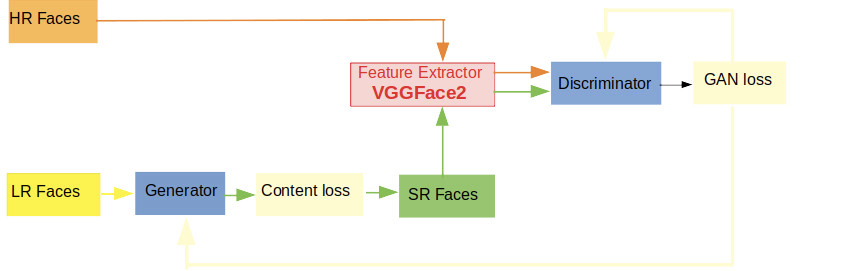

In [ ]:
## Build & compile SRGAN-VGGFace2

In [ ]:
def build_adversarial_model_vggface_vgg16(generator2, discriminator2, vggface_vgg16):
    ## Input layer for high-resolution images
    input_high_resolution2 = Input(shape=high_resolution_shape)
    ## Input layer for low-resolution images
    input_low_resolution2 = Input(shape=low_resolution_shape)
    ## Generate high-resolution images from low-resolution images
    generated_high_resolution_images2 = generator2(input_low_resolution2)
    ## Extract feature maps from generated images
    features2 = vggface_vgg16(generated_high_resolution_images2)
    ## Make a discriminator non-trainable
    discriminator2.trainable = False
    discriminator2.compile(loss='mse', optimizer=common_optimizer2, metrics=['accuracy'])
    ## Discriminator will give us a probability estimation for the generated high-resolution images
    probs2 = discriminator2(generated_high_resolution_images2)
    ## Create and compile
    adversarial_model2 = Model([input_low_resolution2, input_high_resolution2], [probs2, features2])
    adversarial_model2.compile(loss=['binary_crossentropy', 'mse'], loss_weights=[1e-3, 1], optimizer=common_optimizer2)
    return adversarial_model2

In [ ]:
adversarial_model_vggface_vgg16 = build_adversarial_model_vggface_vgg16(generator2, discriminator2, VGGFace2_VGG16)

In [ ]:
## Training loop with SRGAN-VGGFace2

In [ ]:
psnr_2 = {'psnr_quality': []}
psnr_2_faces = {'psnr_quality': []}
psnr_2_right_eyes = {'psnr_quality': []}
psnr_2_left_eyes = {'psnr_quality': []}

ssim_2 = {'ssim_quality': []}
ssim_2_faces = {'ssim_quality': []}
ssim_2_right_eyes = {'ssim_quality': []}
ssim_2_left_eyes = {'ssim_quality': []}

losses2 = {"d_history":[], "g_history":[]}

In [ ]:
for epoch in range(epochs2):
    d_history2 = []
    g_history2 = []
    ## Print("Epoch:{}".format(epoch))
    high_resolution_sources, low_resolution_sources, high_resolution_images_det, low_resolution_images_det, high_resolution_faces, low_resolution_faces, high_resolution_faces_det, low_resolution_faces_det, high_resolution_right_eyes, low_resolution_right_eyes, high_resolution_left_eyes, low_resolution_left_eyes = sample_images(data_dir=data_dir, batch_size=batch_size, low_resolution_shape=low_resolution_shape, high_resolution_shape=high_resolution_shape)
    ## Normalize the images
    high_resolution_images = high_resolution_images_det / 127.5 - 1.
    low_resolution_images = low_resolution_images_det / 127.5 - 1.
    high_resolution_faces_det = high_resolution_faces_det / 127.5 - 1.
    low_resolution_faces_det = low_resolution_faces_det / 127.5 - 1.
    high_resolution_right_eyes = high_resolution_right_eyes / 127.5 - 1.
    low_resolution_right_eyes = low_resolution_right_eyes / 127.5 - 1.
    high_resolution_left_eyes = high_resolution_left_eyes / 127.5 - 1.
    low_resolution_left_eyes = low_resolution_left_eyes / 127.5 - 1.
    ## Generate high-resolution images from low-resolution images
    generated_high_resolution_images2 = generator2.predict(low_resolution_images)
    generated_faces2_det = generator2.predict_on_batch(low_resolution_faces_det)
    generated_right_eyes2 = generator2.predict_on_batch(low_resolution_right_eyes)
    generated_left_eyes2 = generator2.predict_on_batch(low_resolution_left_eyes)
    ## Generate a batch of true and fake labels
    real_labels = np.ones((batch_size, 16, 16, 1))
    fake_labels = np.zeros((batch_size, 16, 16, 1))
    d_loss_real2 = discriminator2.train_on_batch(high_resolution_images, real_labels)
    d_loss_real2 = np.mean(d_loss_real2)
    d_loss_fake2 = discriminator2.train_on_batch(generated_high_resolution_images2, fake_labels)
    d_loss_fake2 = np.mean(d_loss_fake2)
    ## Calculate total loss of discriminator as average loss on true and fake labels
    d_loss2 = 0.5 * np.add(d_loss_real2, d_loss_fake2)
    losses2['d_history'].append(d_loss2)
    ## Print("Discriminator loss:", d_loss2)
    ## Train the generator
    ## Sample the batch with images
    high_resolution_source, low_resolution_source, high_resolution_images_det, low_resolution_images_det, high_resolution_faces, low_resolution_faces, high_resolution_faces_det, low_resolution_faces_det, high_resolution_right_eyes, low_resolution_right_eyes, high_resolution_left_eyes, low_resolution_left_eyes = sample_images(data_dir=data_dir, batch_size=batch_size, low_resolution_shape=low_resolution_shape, high_resolution_shape=high_resolution_shape)
    ## Normalize the images
    high_resolution_images = high_resolution_images_det / 127.5 - 1.
    low_resolution_images = low_resolution_images_det / 127.5 - 1.
    high_resolution_faces_det = high_resolution_faces_det / 127.5 - 1.
    low_resolution_faces_det = low_resolution_faces_det / 127.5 - 1.
    high_resolution_right_eyes = high_resolution_right_eyes / 127.5 - 1.
    low_resolution_right_eyes = low_resolution_right_eyes / 127.5 - 1.
    high_resolution_left_eyes = high_resolution_left_eyes / 127.5 - 1.
    low_resolution_left_eyes = low_resolution_left_eyes / 127.5 - 1.
    ## Extract feature maps for true high-resolution images
    image_features2 = VGGFace2_VGG16.predict(high_resolution_images)
    ## Train the generator
    g_loss2 = adversarial_model_vggface_vgg16.train_on_batch([low_resolution_images, high_resolution_images], [real_labels, image_features2])
    losses2['g_history'].append(0.5 * (g_loss2[1]))
    ## Print( "Generator loss:", 0.5 * (g_loss2[1]) )
    ## Calculate the psnr per generated and original image and add it to the list
    ps_2 = calc_psnr(high_resolution_images, generated_high_resolution_images2)
    ## Print("PSNR:", np.mean(ps_2.numpy()))
    psnr_2['psnr_quality'].append(ps_2)
    ps_2 = calc_psnr(high_resolution_faces_det, generated_faces2_det)
    psnr_2_faces['psnr_quality'].append(ps_2)
    ps_2 = calc_psnr(high_resolution_right_eyes, generated_right_eyes2)
    psnr_2_right_eyes['psnr_quality'].append(ps_2)
    ps_2 = calc_psnr(high_resolution_left_eyes, generated_left_eyes2)
    psnr_2_left_eyes['psnr_quality'].append(ps_2)
    ## Calculate the ssim per generated and original image and add it to the list
    ss_2 = calc_ssim(high_resolution_images, generated_high_resolution_images2)
    ## Print("SSIM:", np.mean(ss_2.numpy()))
    ssim_2['ssim_quality'].append(ss_2)
    ss_2 = calc_psnr(high_resolution_faces_det, generated_faces2_det)
    ssim_2_faces['ssim_quality'].append(ss_2)
    ss_2 = calc_psnr(high_resolution_right_eyes, generated_right_eyes2)
    ssim_2_right_eyes['ssim_quality'].append(ss_2)
    ss_2 = calc_psnr(high_resolution_left_eyes, generated_left_eyes2)
    ssim_2_left_eyes['ssim_quality'].append(ss_2)
    ## save and print image samples
    if (epoch == 50) or (epoch == 100) or (epoch == 150) or (epoch == 200) or (epoch == 250) or (epoch == 300) or (epoch == 350):
        high_resolution_source, low_resolution_source, high_resolution_images_det, low_resolution_images_det, high_resolution_faces, low_resolution_faces, high_resolution_faces_det, low_resolution_faces_det, high_resolution_right_eyes, low_resolution_right_eyes, high_resolution_left_eyes, low_resolution_left_eyes = sample_images(data_dir=data_dir, batch_size=batch_size, low_resolution_shape=low_resolution_shape, high_resolution_shape=high_resolution_shape)
        high_resolution_images = high_resolution_images_det / 127.5 - 1.
        low_resolution_images = low_resolution_images_det / 127.5 - 1.
        high_resolution_faces_det = high_resolution_faces_det / 127.5 - 1.
        low_resolution_faces_det = low_resolution_faces_det / 127.5 - 1.
        high_resolution_right_eyes = high_resolution_right_eyes / 127.5 - 1.
        low_resolution_right_eyes = low_resolution_right_eyes / 127.5 - 1.
        high_resolution_left_eyes = high_resolution_left_eyes / 127.5 - 1.
        low_resolution_left_eyes = low_resolution_left_eyes / 127.5 - 1.
        generated_images2 = generator2.predict_on_batch(low_resolution_images)
        generated_faces2_det = generator2.predict_on_batch(low_resolution_faces_det)
        generated_right_eyes2 = generator2.predict_on_batch(low_resolution_right_eyes)
        generated_left_eyes2 = generator2.predict_on_batch(low_resolution_left_eyes)
        for index, img in enumerate(generated_images2):
            save_images(low_resolution_images[index], high_resolution_images[index], img, path="/Your Data Dir/img2_{}_{}".format(epoch, index))
        for index, img in enumerate(generated_faces2_det):
            save_images(low_resolution_faces_det[index], high_resolution_faces_det[index], img, path="/Your Data Dir/faces2det_{}_{}".format(epoch, index))
        for index, img in enumerate(generated_right_eyes2):
            save_images(low_resolution_right_eyes[index], high_resolution_right_eyes[index], img, path="/Your Data Dir/right_eyes2_{}_{}".format(epoch, index))
        for index, img in enumerate(generated_left_eyes2):
            save_images(low_resolution_left_eyes[index], high_resolution_left_eyes[index], img, path="/Your Data Dir/left_eyes2_{}_{}".format(epoch, index))

In [ ]:
title="SRGAN-VGGFace2-VGG16"
plot_loss(losses2, title)

title="SRGAN-VGGFace2-VGG16 - full images"
plot_psnr(psnr_2, title)
plot_ssim(ssim_2, title)

title="SRGAN-VGGFace2-VGG16 - extracted faces"
plot_psnr(psnr_2_faces, title)
plot_ssim(ssim_2_faces, title)

title="SRGAN-VGGFace2-VGG16 - extracted right eyes"
plot_psnr(psnr_2_right_eyes, title)
plot_ssim(ssim_2_right_eyes, title)

title="SRGAN-VGGFace2-VGG16 - extracted left eyes"
plot_psnr(psnr_2_left_eyes, title)
plot_ssim(ssim_2_left_eyes, title)

In [ ]:
## Experiment 3 - SRGAN-EfficientNet-B0
## Let's substitute the SRGAN Feature Extractor from VGG-19 to EfficientNet B0!

In [ ]:
## SRGAN + EfficientNet

In [ ]:
## Discriminator 3

In [ ]:
def build_discriminator3():
    ## Define hyper-parameters
    leakyrelu_alpha = 0.2
    momentum = 0.8
    ## Dimentions correspond to HR - High Resolution
    input_shape = (256, 256, 3)
    ## Input layer for discriminator
    input_layer = Input(shape=input_shape)
    ## 8 Convolutional layers with batch normalization
    dis1 = Conv2D(filters=64, kernel_size=3, strides=1, padding='same')(input_layer)
    dis1 = LeakyReLU(alpha=leakyrelu_alpha)(dis1)
    
    dis2 = Conv2D(filters=64, kernel_size=3, strides=2, padding='same')(dis1)
    dis2 = LeakyReLU(alpha=leakyrelu_alpha)(dis2)
    dis2 = BatchNormalization(momentum=momentum)(dis2)
    
    dis3 = Conv2D(filters=128, kernel_size=3, strides=1, padding='same')(dis2)
    dis3 = LeakyReLU(alpha=leakyrelu_alpha)(dis3)
    dis3 = BatchNormalization(momentum=momentum)(dis3)
    
    dis4 = Conv2D(filters=128, kernel_size=3, strides=2, padding='same')(dis3)
    dis4 = LeakyReLU(alpha=leakyrelu_alpha)(dis4)
    dis4 = BatchNormalization(momentum=0.8)(dis4)
    
    dis5 = Conv2D(256, kernel_size=3, strides=1, padding='same')(dis4)
    dis5 = LeakyReLU(alpha=leakyrelu_alpha)(dis5)
    dis5 = BatchNormalization(momentum=momentum)(dis5)
    
    dis6 = Conv2D(filters=256, kernel_size=3, strides=2, padding='same')(dis5)
    dis6 = LeakyReLU(alpha=leakyrelu_alpha)(dis6)
    dis6 = BatchNormalization(momentum=momentum)(dis6)
    
    dis7 = Conv2D(filters=512, kernel_size=3, strides=1, padding='same')(dis6)
    dis7 = LeakyReLU(alpha=leakyrelu_alpha)(dis7)
    dis7 = BatchNormalization(momentum=momentum)(dis7)
    
    dis8 = Conv2D(filters=512, kernel_size=3, strides=2, padding='same')(dis7)
    dis8 = LeakyReLU(alpha=leakyrelu_alpha)(dis8)
    dis8 = BatchNormalization(momentum=momentum)(dis8)
    ## Fully-connected layer
    dis9 = Dense(units=1024)(dis8)
    dis9 = LeakyReLU(alpha=0.2)(dis9)
    ## Last fully-connected layer - for classification
    output = Dense(units=1, activation='sigmoid')(dis9)
    
    ## Model
    model = Model(inputs=[input_layer], outputs=[output], name='discriminator')
    return model

In [ ]:
discriminator3 = build_discriminator3()
discriminator3.trainable = True
discriminator3.compile(loss='mse', optimizer=common_optimizer3, metrics=['accuracy'])

In [ ]:
## Generator 3

In [ ]:
def build_generator3():
    ## Use 16 residual blocks in generator
    residual_blocks = 16
    momentum = 0.8
    ## Dimension equals to LR - Low Resolution
    input_shape = (64, 64, 3)
    ## Input layer for the generator network
    input_layer = Input(shape=input_shape)
    ## Pre-residual block: convolutional layer before residual blocks
    gen1 = Conv2D(filters=64, kernel_size=9, strides=1, padding='same', activation='relu')(input_layer)
    ## Add 16 residual blocks
    res = residual_block(gen1)
    for i in range(residual_blocks - 1):
        res = residual_block(res)
    ## Post-residual block: convolutional layer and batch-norm layer after residual blocks
    gen2 = Conv2D(filters=64, kernel_size=3, strides=1, padding='same')(res)
    gen2 = BatchNormalization(momentum=momentum)(gen2)
    ## Take the sum of pre-residual block(gen1) and post-residual block(gen2)
    gen3 = Add()([gen2, gen1])
    ## UpSampling: learning to increase dimensionality
    gen4 = UpSampling2D(size=2)(gen3)
    gen4 = Conv2D(filters=256, kernel_size=3, strides=1, padding='same')(gen4)
    gen4 = Activation('relu')(gen4)
    ## UpSampling: learning to increase dimensionality
    gen5 = UpSampling2D(size=2)(gen4)
    gen5 = Conv2D(filters=256, kernel_size=3, strides=1, padding='same')(gen5)
    gen5 = Activation('relu')(gen5)
    ## Convolution layer at the output
    gen6 = Conv2D(filters=3, kernel_size=9, strides=1, padding='same')(gen5)
    output = Activation('tanh')(gen6)
    # Model
    model = Model(inputs=[input_layer], outputs=[output], name='generator')
    return model

In [ ]:
generator3 = build_generator3()

In [ ]:
## Feature Extractor based on EfficientNet-B0

In [ ]:
import efficientnet.keras as efn

In [ ]:
B0_base = efn.EfficientNetB0(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
B0_base.trainable = True

In [ ]:
plot_model(B0_base, to_file='B0_base2.png', show_shapes=True)
Image(filename='B0_base2.png')

In [ ]:
def build_B0():
    input_shape = (256, 256, 3)
    B0_base.outputs = [B0_base.get_layer('block6a_expand_conv').output]
    input_layer = Input(shape=input_shape)
    features = B0_base(input_layer)
    model = Model(inputs=[input_layer], outputs=[features])
    return model
B0 = build_B0()
B0.trainable = False
B0.compile(loss='mse', optimizer=common_optimizer3, metrics=['accuracy'])

In [ ]:
## SRGAN-EfficientNet-B0

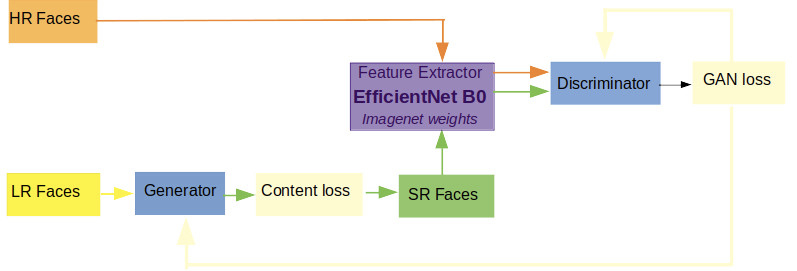
Figure - SRGAN_EfficientNet-B0 Conceptual Architecture

In [ ]:
## Build & compile SRGAN-EfficientNet-B0

In [ ]:
def build_adversarial_model_B0(generator3, discriminator3, B0):
    ## Input layer for high-resolution images
    input_high_resolution3 = Input(shape=high_resolution_shape)
    ## Input layer for low-resolution images
    input_low_resolution3 = Input(shape=low_resolution_shape)
    ## Generate high-resolution images from low-resolution images
    generated_high_resolution_images3 = generator3(input_low_resolution3)
    ## Extract feature maps from generated images
    features3 = B0(generated_high_resolution_images3)
    ## Make a discriminator non-trainable
    discriminator3.trainable = False
    discriminator3.compile(loss='mse', optimizer=common_optimizer3, metrics=['accuracy'])
    ## Discriminator will give us a probability estimation for the generated high-resolution images
    probs3 = discriminator3(generated_high_resolution_images3)
    ## Create and compile
    adversarial_model3 = Model([input_low_resolution3, input_high_resolution3], [probs3, features3])
    adversarial_model3.compile(loss=['binary_crossentropy', 'mse'], loss_weights=[1e-3, 1], optimizer=common_optimizer3)
    return adversarial_model3

In [ ]:
adversarial_model_B0 = build_adversarial_model_B0(generator3, discriminator3, B0)

In [ ]:
## Training loop with SRGAN-EfficientNet-B0

In [ ]:
psnr_3 = {'psnr_quality': []}
psnr_3_faces = {'psnr_quality': []}
psnr_3_right_eyes = {'psnr_quality': []}
psnr_3_left_eyes = {'psnr_quality': []}

ssim_3 = {'ssim_quality': []}
ssim_3_faces = {'ssim_quality': []}
ssim_3_right_eyes = {'ssim_quality': []}
ssim_3_left_eyes = {'ssim_quality': []}

losses3 = {"d_history":[], "g_history":[]}

In [ ]:
for epoch in range(epochs3):
    d_history3 = []
    g_history3 = []
    ## Print("Epoch:{}".format(epoch))
    high_resolution_sources, low_resolution_sources, high_resolution_images_det, low_resolution_images_det, high_resolution_faces, low_resolution_faces, high_resolution_faces_det, low_resolution_faces_det, high_resolution_right_eyes, low_resolution_right_eyes, high_resolution_left_eyes, low_resolution_left_eyes = sample_images(data_dir=data_dir, batch_size=batch_size, low_resolution_shape=low_resolution_shape, high_resolution_shape=high_resolution_shape)
    ## Normalize the images
    high_resolution_images = high_resolution_images_det / 127.5 - 1.
    low_resolution_images = low_resolution_images_det / 127.5 - 1.
    high_resolution_faces_det = high_resolution_faces_det / 127.5 - 1.
    low_resolution_faces_det = low_resolution_faces_det / 127.5 - 1.
    high_resolution_right_eyes = high_resolution_right_eyes / 127.5 - 1.
    low_resolution_right_eyes = low_resolution_right_eyes / 127.5 - 1.
    high_resolution_left_eyes = high_resolution_left_eyes / 127.5 - 1.
    low_resolution_left_eyes = low_resolution_left_eyes / 127.5 - 1.
    ## Generate high-resolution images from low-resolution images
    generated_high_resolution_images3 = generator3.predict(low_resolution_images)
    generated_faces3_det = generator3.predict_on_batch(low_resolution_faces_det)
    generated_right_eyes3 = generator3.predict_on_batch(low_resolution_right_eyes)
    generated_left_eyes3 = generator3.predict_on_batch(low_resolution_left_eyes)
    ## Generate a batch of true and fake labels
    real_labels = np.ones((batch_size, 16, 16, 1))
    fake_labels = np.zeros((batch_size, 16, 16, 1))
    d_loss_real3 = discriminator3.train_on_batch(high_resolution_images, real_labels)
    d_loss_real3 = np.mean(d_loss_real3)
    d_loss_fake3 = discriminator3.train_on_batch(generated_high_resolution_images3, fake_labels)
    d_loss_fake3 = np.mean(d_loss_fake3)
    ## Calculate total loss of discriminator as average loss on true and fake labels
    d_loss3 = 0.5 * np.add(d_loss_real3, d_loss_fake3)
    losses3['d_history'].append(d_loss3)
    ## Print("Discriminator loss:", d_loss3)
    ## Train the generator
    ## Sample the batch with images
    high_resolution_source, low_resolution_source, high_resolution_images_det, low_resolution_images_det, high_resolution_faces, low_resolution_faces, high_resolution_faces_det, low_resolution_faces_det, high_resolution_right_eyes, low_resolution_right_eyes, high_resolution_left_eyes, low_resolution_left_eyes = sample_images(data_dir=data_dir, batch_size=batch_size, low_resolution_shape=low_resolution_shape, high_resolution_shape=high_resolution_shape)
    ## Normalize the images
    high_resolution_images = high_resolution_images_det / 127.5 - 1.
    low_resolution_images = low_resolution_images_det / 127.5 - 1.
    high_resolution_faces_det = high_resolution_faces_det / 127.5 - 1.
    low_resolution_faces_det = low_resolution_faces_det / 127.5 - 1.
    high_resolution_right_eyes = high_resolution_right_eyes / 127.5 - 1.
    low_resolution_right_eyes = low_resolution_right_eyes / 127.5 - 1.
    high_resolution_left_eyes = high_resolution_left_eyes / 127.5 - 1.
    low_resolution_left_eyes = low_resolution_left_eyes / 127.5 - 1.
    ## Extract feature maps for true high-resolution images
    image_features3 = B0.predict(high_resolution_images)
    ## Train the generator
    g_loss3 = adversarial_model_B0.train_on_batch([low_resolution_images, high_resolution_images], [real_labels, image_features3])
    losses3['g_history'].append(0.5 * (g_loss3[1]))
    ## Print( "Generator loss:", 0.5 * (g_loss3[1]) )
    ## Calculate the psnr per generated and original image and add it to the list
    ps_3 = calc_psnr(high_resolution_images, generated_high_resolution_images3)
    ## Print("PSNR:", np.mean(ps_3.numpy()))
    psnr_3['psnr_quality'].append(ps_3)
    ps_3 = calc_psnr(high_resolution_faces_det, generated_faces3_det)
    psnr_3_faces['psnr_quality'].append(ps_3)
    ps_3 = calc_psnr(high_resolution_right_eyes, generated_right_eyes3)
    psnr_3_right_eyes['psnr_quality'].append(ps_3)
    ps_3 = calc_psnr(high_resolution_left_eyes, generated_left_eyes3)
    psnr_3_left_eyes['psnr_quality'].append(ps_3)
    ## Calculate the ssim per generated and original image and add it to the list
    ss_3 = calc_ssim(high_resolution_images, generated_high_resolution_images3)
    ## Print("SSIM:", np.mean(ss_3.numpy()))
    ssim_3['ssim_quality'].append(ss_3)
    ss_3 = calc_psnr(high_resolution_faces_det, generated_faces3_det)
    ssim_3_faces['ssim_quality'].append(ss_3)
    ss_3 = calc_psnr(high_resolution_right_eyes, generated_right_eyes3)
    ssim_3_right_eyes['ssim_quality'].append(ss_3)
    ss_3 = calc_psnr(high_resolution_left_eyes, generated_left_eyes3)
    ssim_3_left_eyes['ssim_quality'].append(ss_3)
    ## Save and print image samples
    if (epoch == 50) or (epoch == 100) or (epoch == 150) or (epoch == 200) or (epoch == 250) or (epoch == 300) or (epoch == 350):
        high_resolution_source, low_resolution_source, high_resolution_images_det, low_resolution_images_det, high_resolution_faces, low_resolution_faces, high_resolution_faces_det, low_resolution_faces_det, high_resolution_right_eyes, low_resolution_right_eyes, high_resolution_left_eyes, low_resolution_left_eyes = sample_images(data_dir=data_dir, batch_size=batch_size, low_resolution_shape=low_resolution_shape, high_resolution_shape=high_resolution_shape)
        ## Normalize the images
        high_resolution_images = high_resolution_images_det / 127.5 - 1.
        low_resolution_images = low_resolution_images_det / 127.5 - 1.
        high_resolution_faces_det = high_resolution_faces_det / 127.5 - 1.
        low_resolution_faces_det = low_resolution_faces_det / 127.5 - 1.
        high_resolution_right_eyes = high_resolution_right_eyes / 127.5 - 1.
        low_resolution_right_eyes = low_resolution_right_eyes / 127.5 - 1.
        high_resolution_left_eyes = high_resolution_left_eyes / 127.5 - 1.
        low_resolution_left_eyes = low_resolution_left_eyes / 127.5 - 1.
        generated_images3 = generator3.predict_on_batch(low_resolution_images)
        generated_faces3_det = generator3.predict_on_batch(low_resolution_faces_det)
        generated_right_eyes3 = generator3.predict_on_batch(low_resolution_right_eyes)
        generated_left_eyes3 = generator3.predict_on_batch(low_resolution_left_eyes)
        for index, img in enumerate(generated_images3):
            save_images(low_resolution_images[index], high_resolution_images[index], img, path="/Your Data Dir/img3_{}_{}".format(epoch, index))
        for index, img in enumerate(generated_faces3_det):
            save_images(low_resolution_faces_det[index], high_resolution_faces_det[index], img, path="/Your Data Dir/faces3det_{}_{}".format(epoch, index))
        for index, img in enumerate(generated_right_eyes3):
            save_images(low_resolution_right_eyes[index], high_resolution_right_eyes[index], img, path="/Your Data Dir/right_eyes3_{}_{}".format(epoch, index))
        for index, img in enumerate(generated_left_eyes3):
            save_images(low_resolution_left_eyes[index], high_resolution_left_eyes[index], img, path="/Your Data Dir/left_eyes3_{}_{}".format(epoch, index))

In [ ]:
title="SRGAN-EfficientNet-B0"
plot_loss(losses3, title)

title="SRGAN-EfficientNet-B0 - full images"
plot_psnr(psnr_3, title)
plot_ssim(ssim_3, title)

title="SRGAN-EfficientNet-B0 - extracted faces"
plot_psnr(psnr_3_faces, title)
plot_ssim(ssim_3_faces, title)

title="SRGAN-EfficientNet-B0 - extracted right eyes"
plot_psnr(psnr_3_right_eyes, title)
plot_ssim(ssim_3_right_eyes, title)

title="SRGAN-EfficientNet-B0 - extracted left eyes"
plot_psnr(psnr_3_left_eyes, title)
plot_ssim(ssim_3_left_eyes, title)

In [ ]:
## Save models weights

In [ ]:
generator1.save_weights("/Your Data Dir/generator1.h5")
discriminator1.save_weights("/Your Data Dir/discriminator1.h5")

In [ ]:
generator2.save_weights("/Your Data Dir/generator2.h5")
discriminator2.save_weights("/Your Data Dir/discriminator2.h5")

In [ ]:
generator3.save_weights("/Your Data Dir/generator3.h5")
discriminator3.save_weights("/Your Data Dir/discriminator3.h5")

In [ ]:
## SRGAN-VGG19 + SRGAN-VGGFace2 + SRGAN-EfficientNet-B0 plots

In [ ]:
title1="SRGAN-VGG19"
title2="SRGAN-VGGFace2-VGG16"
title3="SRGAN-EfficientNet-B0"

plot_loss12(losses1, losses2, title1, title2)
plot_loss12(losses1, losses3, title1, title3)
plot_loss12(losses2, losses3, title2, title3)

plot_loss123(losses1, losses2, losses3, title1, title2, title3)

In [ ]:
title1="SRGAN-VGG19 - full images"
title2="SRGAN-VGGFace2-VGG16 - full images"
title3="SRGAN-EfficientNet-B0 - full images"

plot_psnr12(psnr_1, psnr_2, title1, title2)
plot_ssim12(ssim_1, ssim_2, title1, title2)

plot_psnr12(psnr_1, psnr_3, title1, title3)
plot_ssim12(ssim_1, ssim_3, title1, title3)

plot_psnr12(psnr_2, psnr_3, title2, title3)
plot_ssim12(ssim_2, ssim_3, title2, title3)

plot_psnr123(psnr_1, psnr_2, psnr_3, title1, title2, title3)
plot_ssim123(ssim_1, ssim_2, ssim_3, title1, title2, title3)

In [ ]:
title1="SRGAN-VGG19 - extracted faces"
title2="SRGAN-VGGFace2-VGG16 - extracted faces"
title3="SRGAN-EfficientNet-B0 - extracted faces"

plot_psnr12(psnr_1_faces, psnr_2_faces, title1, title2)
plot_ssim12(ssim_1_faces, ssim_2_faces, title1, title2)

plot_psnr12(psnr_1_faces, psnr_3_faces, title1, title3)
plot_ssim12(ssim_1_faces, ssim_3_faces, title1, title3)

plot_psnr12(psnr_2_faces, psnr_3_faces, title2, title3)
plot_ssim12(ssim_2_faces, ssim_3_faces, title2, title3)

plot_psnr123(psnr_1_faces, psnr_2_faces, psnr_3_faces, title1, title2, title3)
plot_ssim123(ssim_1_faces, ssim_2_faces, ssim_3_faces, title1, title2, title3)

In [ ]:
title1="SRGAN-VGG19 - extracted right eyes"
title2="SRGAN-VGGFace2-VGG16 - extracted right eyes"
title3="SRGAN-EfficientNet-B0 - extracted right eyes"

plot_psnr12(psnr_1_right_eyes, psnr_2_right_eyes, title1, title2)
plot_ssim12(ssim_1_right_eyes, ssim_2_right_eyes, title1, title2)

plot_psnr12(psnr_1_right_eyes, psnr_3_right_eyes, title1, title3)
plot_ssim12(ssim_1_right_eyes, ssim_3_right_eyes, title1, title3)

plot_psnr12(psnr_2_right_eyes, psnr_3_right_eyes, title2, title3)
plot_ssim12(ssim_2_right_eyes, ssim_3_right_eyes, title2, title3)

plot_psnr123(psnr_1_right_eyes, psnr_2_right_eyes, psnr_3_right_eyes, title1, title2, title3)
plot_ssim123(ssim_1_right_eyes, ssim_2_right_eyes, ssim_3_right_eyes, title1, title2, title3)

In [ ]:
title1="SRGAN-VGG19 - extracted left eyes"
title2="SRGAN-VGGFace2-VGG16 - extracted left eyes"
title3="SRGAN-EfficientNet-B0 - extracted left eyes"

plot_psnr12(psnr_1_left_eyes, psnr_2_left_eyes, title1, title2)
plot_ssim12(ssim_1_left_eyes, ssim_2_left_eyes, title1, title2)

plot_psnr12(psnr_1_left_eyes, psnr_3_left_eyes, title1, title3)
plot_ssim12(ssim_1_left_eyes, ssim_3_left_eyes, title1, title3)

plot_psnr12(psnr_2_left_eyes, psnr_3_left_eyes, title2, title3)
plot_ssim12(ssim_2_left_eyes, ssim_3_left_eyes, title2, title3)

plot_psnr123(psnr_1_left_eyes, psnr_2_left_eyes, psnr_3_left_eyes, title1, title2, title3)
plot_ssim123(ssim_1_left_eyes, ssim_2_left_eyes, ssim_3_left_eyes, title1, title2, title3)